# TP Black Hole

- https://web.archive.org/web/20180321162912/https://losc.ligo.org/events/GW150914/
- https://web.archive.org/web/20180615185011/https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.html
- https://www.gw-openscience.org/eventapi/html/O3_Discovery_Papers/GW190814/v1/
- https://pypi.org/project/pyFFTW/

## Loading Dataset



https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/



In [ ]:
import numpy as np

% pip install pyFFTW
import pyfftw

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import seaborn as sn
import scipy as sp

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import importlib.util
spec = importlib.util.spec_from_file_location("readligo", "/content/drive/Shared drives/PASA/TP1 Black Hole/readligo/readligo.py")
readligo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(readligo)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
use_32_seconds = True

if use_32_seconds is True:
  strain_H1, time_H1, chan_dict_H1 = readligo.loaddata("/content/drive/Shared drives/PASA/TP1 Black Hole/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5", 'H1');
  strain_L1, time_L1, chan_dict_L1 = readligo.loaddata("/content/drive/Shared drives/PASA/TP1 Black Hole/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5", 'L1');
else:
  strain_H1, time_H1, chan_dict_H1 = readligo.loaddata("/content/drive/Shared drives/PASA/TP1 Black Hole/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5", 'H1');
  strain_L1, time_L1, chan_dict_L1 = readligo.loaddata("/content/drive/Shared drives/PASA/TP1 Black Hole/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5", 'L1');


# sampling rate:
fs = 4096

/content/drive/Shared drives/PASA/TP1 Black Hole/readligo/readligo.py:132: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
/content/drive/Shared drives/PASA/TP1 Black Hole/readligo/readligo.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
/content/drive/Shared drives/PASA/TP1 Black Hole/readligo/readligo.py:143: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


Separacion de los datos de Ruido ambiente, y sonido recibido, se selecciona un tiempo de guarda entre señales de 100 samples. Hay 15 segundos, 2 segundo de burst, 15 silencio de nuevo.

In [ ]:
# Duración del evento en samples
event_duration = int(fs * 0.2)

# Donde comienza el evento
index_H1 = np.where(time_H1 >= 1126259462.4)[0][0]

#print(f"Principio del evento {index_H1}")
guarda = 100
#H1
silencio_1_H1 = strain_H1[0 : (index_H1 - guarda)]

evento_H1 = strain_H1[ index_H1: (event_duration + index_H1 )]
tiempo_evento = time_H1[index_H1: (event_duration + index_H1 )]
silencio_2_H1 = strain_H1[ event_duration + index_H1 + guarda : event_duration + index_H1 + guarda + len(silencio_1_H1)]


index_L1 = np.where(time_L1 >= 1126259462.4)[0][0]
#L1
silencio_1_L1 = strain_L1[0 : (index_L1 - guarda)]
evento_L1 = strain_L1[ index_L1 : (event_duration + index_L1)]
silencio_2_L1 = strain_L1[ event_duration + index_L1 + guarda : event_duration + index_L1 + guarda + len(silencio_1_L1)]



silencio_1_H1 = silencio_1_H1 - np.mean(silencio_1_H1)
silencio_2_H1 = silencio_2_H1 - np.mean(silencio_2_H1)
silencio_1_L1 = silencio_1_L1 - np.mean(silencio_1_L1)
silencio_2_L1 = silencio_2_L1 - np.mean(silencio_2_L1)

if not use_32_seconds:
  scale_factor = 10
  silencio_1_H1 = silencio_1_H1[:len(silencio_1_H1)//scale_factor]
  silencio_2_H1 = silencio_2_H1[:len(silencio_2_H1)//scale_factor]
  silencio_1_L1 = silencio_1_L1[:len(silencio_1_L1)//scale_factor]
  silencio_2_L1 = silencio_2_L1[:len(silencio_2_L1)//scale_factor]

from scipy import signal
silencio_1_H1 = silencio_1_H1 * signal.windows.hann(len(silencio_1_H1))
silencio_2_H1 = silencio_2_H1 * signal.windows.hann(len(silencio_2_H1))
silencio_1_L1 = silencio_1_L1 * signal.windows.hann(len(silencio_1_L1))
silencio_2_L1 = silencio_2_L1 * signal.windows.hann(len(silencio_2_L1))

# Removemos la media
evento_H1  = evento_H1 - np.mean(evento_H1)
evento_L1  = evento_L1 - np.mean(evento_L1)

evento_H1  = evento_H1 * signal.windows.hann(len(evento_H1))
evento_L1  = evento_L1 * signal.windows.hann(len(evento_L1))


silences = [silencio_1_H1, silencio_2_H1, silencio_1_L1, silencio_2_L1]
events = [evento_H1, evento_L1]
titles = ["Periodograma 1er silencio Hanford", "Periodograma 2do silencio Hanford", "Periodograma 1er silencio Livingston", "Periodograma 2do silencio Livingston"]
# plot_axis = [1,1e4,1e-25,1e-18]
plot_axis = [1,2e3,5e-21,1e-14]

del silencio_1_H1
del silencio_2_H1
del silencio_1_L1
del silencio_2_L1
del evento_H1
del evento_L1
del index_H1
del index_L1
del guarda

En la siguiente figura se muestra la señal de entrada de Livingston

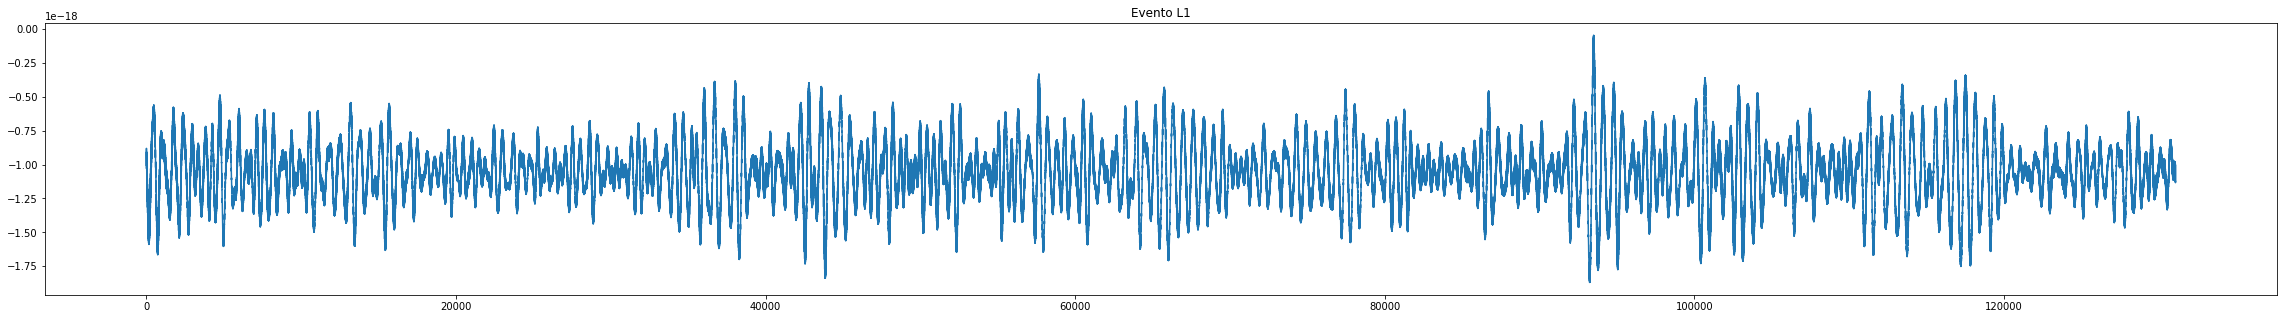

In [ ]:
plt.figure(figsize=(40,5));
plt.title("Evento L1");
plt.plot(strain_L1);

En la siguiente figura se muestra la señal de entrada de Hanford

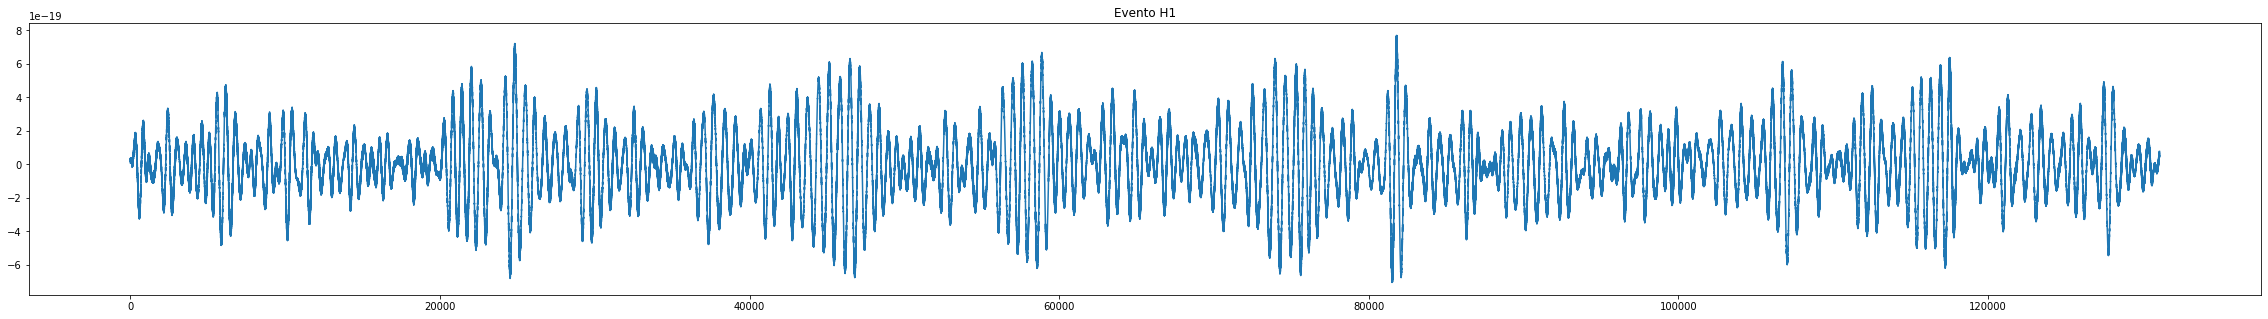

In [ ]:
plt.figure(figsize=(40,5));
plt.title("Evento H1");
plt.plot(strain_H1);

## Estimación del espectro de ruido mediante FFT 

Analizamos la media y la varianza de los periodos de silencio.

In [ ]:
means = []
vars = []
for silence in silences:
  means.append(np.mean(silence))
  vars.append(np.var(silence))

print(f"La media de H1 para el primer tramo es {means[0]}")
print(f"La media de H1 para el segundo tramo es {means[1]}")
print(f"La media de L1 para el primer tramo es {means[2]}")
print(f"La media de L1 para el segundo tramo es {means[3]}")

La media de H1 para el primer tramo es -7.01344584445699e-22
La media de H1 para el segundo tramo es -2.1832757767354397e-21
La media de L1 para el primer tramo es 3.1521097516571416e-22
La media de L1 para el segundo tramo es -1.0890712536072609e-24


Se procede a calcular la autocorrelacion de cada silencio respectivamente

In [ ]:
# Autocorrelaciones de los periodos de silencio restandoles la media
import time
start = time.time()

autocorrelations = []
event_autocorrelations = []

for silence in silences:
  #autocorrelations.append(np.correlate(silence, silence, mode="full") / (2*len(silence)-1))
  # autocorrelations.append(signal.correlate(silence, silence, method= "fft")/ len(silence)**2)
  autocorrelations.append(signal.correlate(silence, silence, method= "fft")) 


for event in events:
  #event_autocorrelations.append(np.correlate(event, event, mode="full") / (2*len(event)-1))
  # autocorrelations.append(signal.correlate(silence, silence, method= "fft")/ len(silence)**2)
  event_autocorrelations.append(signal.correlate(event, event, method= "fft"))


end = time.time()
print("Execution Time: ",(end-start),"(segs)")

Execution Time:  0.04124164581298828 (segs)


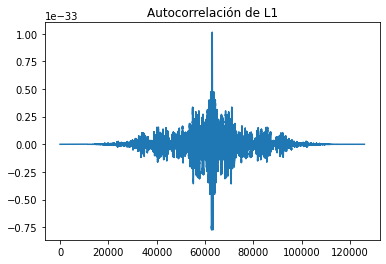

In [ ]:
plt.title("Autocorrelación de L1")
plt.plot(autocorrelations[2]);

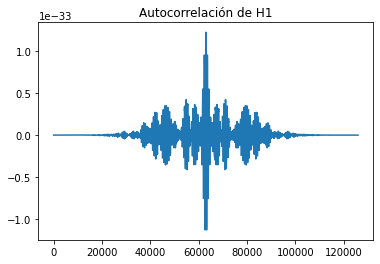

In [ ]:
plt.title("Autocorrelación de H1")
plt.plot(autocorrelations[0]);

Se calcula la DFT de la autocorrelacion de cada una, y luego, para llegar al espectro de la señal, se le aplica la raiz cuadrada

In [ ]:
# Calculamos la transformada de la autocorrelación para obtener la PSD (power spectral density)
psds = []
psd_freqs = []
for autocorrelation in autocorrelations:
  ESD = np.abs(np.fft.fft(autocorrelation))
  PSD = ESD #Corregir
  psds.append(PSD)
  psd_freqs.append(np.fft.fftfreq(len(PSD), d=1.0/fs))

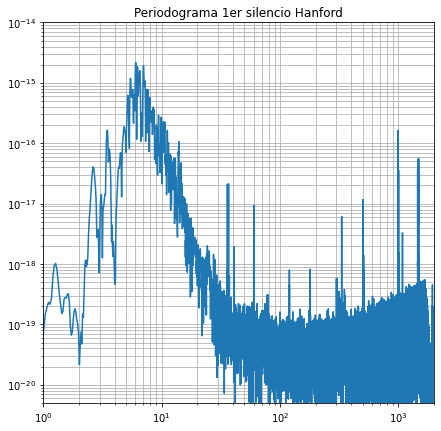

In [ ]:
data_selection = 0
plt.figure(figsize=(7,7))
plt.axis(plot_axis)
plt.grid(axis='both', which='both')
plt.title(titles[data_selection])
plt.loglog(psd_freqs[data_selection], np.sqrt(psds[data_selection]));

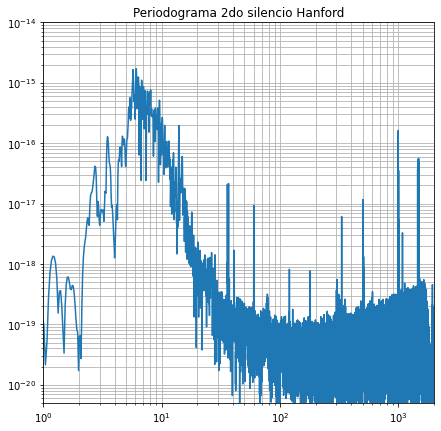

In [ ]:
data_selection = 1
plt.figure(figsize=(7,7))
plt.axis(plot_axis)
plt.grid(axis='both', which='both')
plt.title(titles[data_selection])
plt.loglog(psd_freqs[data_selection], np.sqrt(psds[data_selection]));

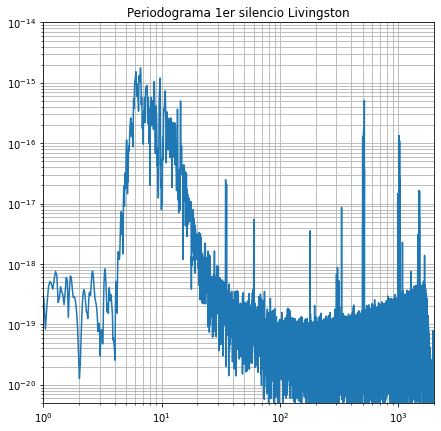

In [ ]:
data_selection = 2
plt.figure(figsize=(7,7))
plt.axis(plot_axis)
plt.grid(axis='both', which='both')
plt.title(titles[data_selection])
plt.loglog(psd_freqs[data_selection], np.sqrt(psds[data_selection]));

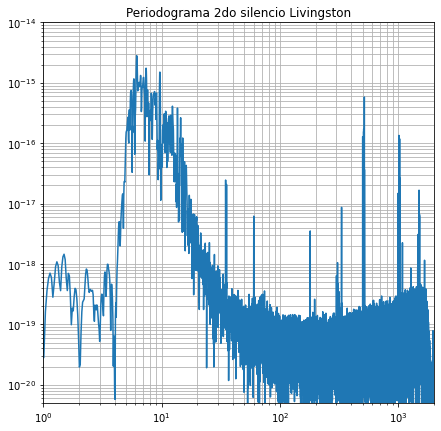

In [ ]:
data_selection = 3
plt.figure(figsize=(7,7))
plt.axis(plot_axis)
plt.grid(axis='both', which='both')
plt.title(titles[data_selection])
plt.loglog(psd_freqs[data_selection], np.sqrt(psds[data_selection]));
del data_selection

## Estimación del espectro mediante el método de Blackman-Tukey


El metodo de Blackman Tukey ofrece un suavizado en el espectro ofreciendo una ventaja computacional por su metodo de calculo.

Material de referencia
Pagina 222 Manolakis

- N: tamaño del vector de la data
- L: tamaño de la ventana rectangular en el espectro

Los pasos seguido a continuacion son:

- Calcular la autocorrelacion desde -(L-1) hasta L-1
- Ventanear la autocorrelacion con la ventana:

$$\omega_a(l)=\frac{sin\left(l\frac{\Delta \omega}{2}\right)}{\pi l}$$

- Calcular la DFT utilizando la FFT

Por lo tanto, obtenemos:

$$\hat{R_x}(e^{j\omega})|_{\omega=\frac{2k}{N_{FFT}}}$$

La funcion **get_ventana_bktukey(M,N)** devuelve una ventana como la que se menciono anteriormente de 2N-2 valores

In [ ]:
def get_ventana_bktukey(M,N):
  delta_omega = (2*np.pi/N)*(2*M+1)
  time = np.arange(-N+1,N)
  window = np.sinc(time*delta_omega/(2*np.pi)) * (delta_omega/(2*np.pi))
                                                # No se que onda, hice el calculo y ese factor en la multiplicacion
                                                # deberia estar, sin embargo, cuando no lo pongo y ploteo da mejor.(sin offset)
  print(window)
  window = window/max(window)                                    
  return window

Aca se obtiene la ventana deseada para el 1er silencio (los primeros 15 segundos de la señal de Hanford), se multiplica la autocorrelacion por la ventana obtenida y se le aplica la fft y la raiz cuadrada para obtener el espectro de la señal.

In [ ]:
def plot_BT(silencio, autocorr, psd, frec_vector,  title):
  win = get_ventana_bktukey(15, len(silencio))
  prod_win_corr = win*autocorr
  spectre_bktukey = np.abs(np.fft.fft(prod_win_corr))
  freq_bktukey = np.fft.fftfreq(len(spectre_bktukey), d=1/fs)

  plt.figure(figsize=(7,7))
  plt.loglog(frec_vector, np.sqrt(psd), label="Original");
  plt.loglog(freq_bktukey, np.sqrt(spectre_bktukey), label="Blackman Tukey");
  plt.grid(axis='both', which='both')
  plt.axis(plot_axis)
  plt.title(title)
  plt.legend();

Cargo en la variable **btuckey_spectres** los espectros de cada caso con la estimacion de Blackman-Tuckey , y en la variable **btuckey_freqs** las respectivasa frecuencias

In [ ]:
def do_btuckey(X, auto_corr, fs, M=15, n=None, absolute=True):
  window = get_ventana_bktukey(M, len(X)) 
  if n is None:
    psd_spectre = np.fft.fft(window*auto_corr)
  else :
    psd_spectre = np.fft.fft(window*auto_corr, n=n)

  if absolute is True:
    psd_spectre = np.abs(psd_spectre) 

  freqs = np.fft.fftfreq(len(auto_corr), d=1/fs)
  return freqs, psd_spectre

In [ ]:
btuckey_spectres = []
btuckey_freqs = []
for index, silence in enumerate(silences):
  window = get_ventana_bktukey(15, len(silence))
  btuckey_spectres.append(np.abs(np.fft.fft(window*autocorrelations[index])))
  btuckey_freqs.append(np.fft.fftfreq(len(btuckey_spectres[index]), d=1/fs))

[7.81586223e-09 1.56319540e-08 2.34482566e-08 ... 2.34482566e-08
 1.56319540e-08 7.81586223e-09]
[7.81586223e-09 1.56319540e-08 2.34482566e-08 ... 2.34482566e-08
 1.56319540e-08 7.81586223e-09]
[7.81586223e-09 1.56319540e-08 2.34482566e-08 ... 2.34482566e-08
 1.56319540e-08 7.81586223e-09]
[7.81586223e-09 1.56319540e-08 2.34482566e-08 ... 2.34482566e-08
 1.56319540e-08 7.81586223e-09]


[7.81586223e-09 1.56319540e-08 2.34482566e-08 ... 2.34482566e-08
 1.56319540e-08 7.81586223e-09]


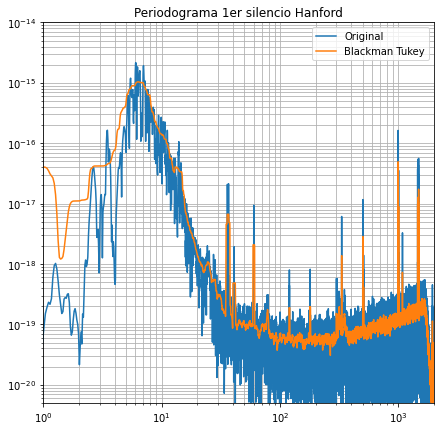

In [ ]:
data_selection = 0
plot_BT(silences[data_selection],autocorrelations[data_selection], psds[data_selection],psd_freqs[data_selection], titles[data_selection])

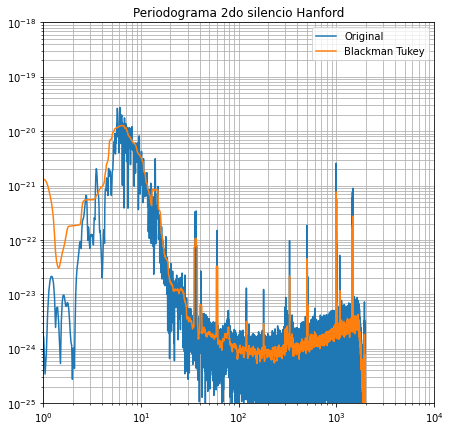

In [ ]:
data_selection = 1
plot_BT(silences[data_selection],autocorrelations[data_selection],psds[data_selection],psd_freqs[data_selection], titles[data_selection])

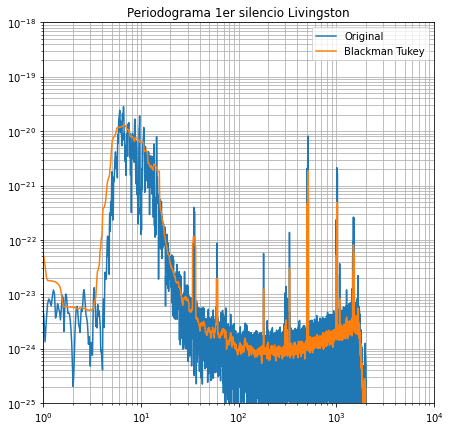

In [ ]:
data_selection = 2
plot_BT(silences[data_selection],autocorrelations[data_selection],psds[data_selection],psd_freqs[data_selection], titles[data_selection])

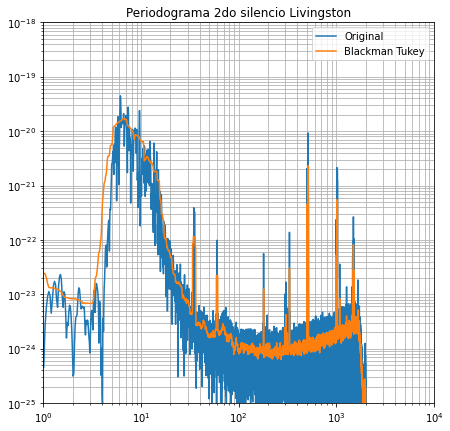

In [ ]:
data_selection = 3
plot_BT(silences[data_selection],autocorrelations[data_selection],psds[data_selection],psd_freqs[data_selection], titles[data_selection])
del data_selection

Como se puede observar, hay una gran mejora respecto a la suavidad del espectro y se obtiene una mejor representacion del espectro real de la señal.

## Estimación del espectro mediante el método de Welch-Bartlett

Este metodo apunta a disminuir la varianza de la estimacion del espectro mediante la promediacion de muchas FFTS.

La siguiente función parte los datos en varios segmentos de igual longitud, les calcula la FFT por separado de cada segmento, y las promedia.

In [ ]:
from scipy import signal

def do_welch_barlett(data, k):
  data = data - np.mean(data)
  new_len = int(len(data)/k)
  splits = []
  win = signal.windows.hann(new_len)
  for i in range(k):
    new_segment = []
    for u in range(new_len):
      new_segment.append(data[u+(i)*new_len])
    splits.append(new_segment * win)
  #print(len(data))
  #print(len(splits[0])*k)
  ffts = []
  auto_corrrr = []
  for segment in splits:
    #auto_cors = np.correlate(segment, segment, mode='full') / len(segment)
    auto_cors = signal.correlate(segment, segment, method="fft") / (2*len(segment))**2
    auto_corrrr.append(auto_cors)
    ffts.append(np.abs(np.fft.fft(auto_cors)))
  avg_ffts = np.mean(ffts, axis=0)
  return avg_ffts

In [ ]:
def plot_WB(silencio, autocorr, psd, frec_vector,  title):
  n = 15
  f, pptx = signal.welch(silencio, fs, noverlap=0, nperseg= int(len(silencio)/n))
  WB = do_welch_barlett(silencio, n)
  freq = np.fft.fftfreq(len(WB), d=1/fs)
  plt.figure(figsize=(7,7));
  plt.loglog(frec_vector, np.sqrt(psd), label="Original");
  #plt.loglog(freq_bktukey_1_H1, np.sqrt(spectre_bktukey_1_H1), label="Blackman Tukey");
  plt.loglog(freq, np.sqrt(WB) ,label="Welch-Bartlett");
  #plt.loglog(f, np.sqrt(pptx) ,label="Welch-Bartlett - Scipy");
  plt.grid(axis='both', which='both');
  plt.axis(plot_axis);
  plt.title(title);
  plt.legend();

Cargo en la variable **wbartlett_spectres** los espectros de cada caso con la estimacion de Welch-Bartlett , y en la variable **wbartlett_freqs** las respectivas frecuencias

In [ ]:
wbartlett_spectres = []
wbartlett_freqs = []
for index, silence in enumerate(silences):
  n = 15
  wbartlett_spectres.append(do_welch_barlett(silence, n))
  wbartlett_freqs.append(np.fft.fftfreq(len(wbartlett_spectres[index]), d=1/fs))

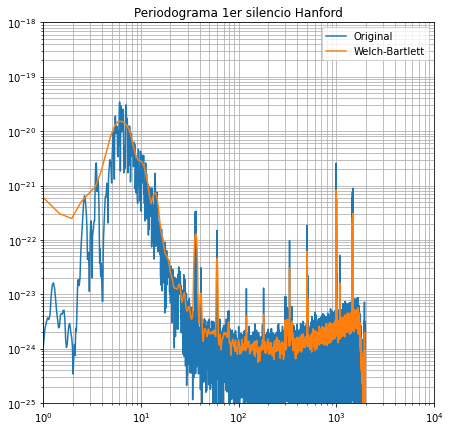

In [ ]:
data_selection = 0
plot_WB(silences[data_selection], autocorrelations[data_selection], psds[data_selection], psd_freqs[data_selection],  titles[data_selection]);

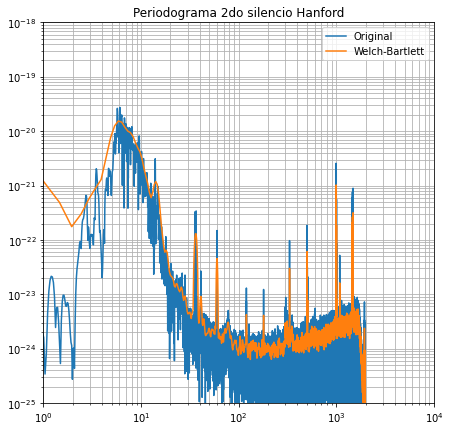

In [ ]:
data_selection = 1
plot_WB(silences[data_selection], autocorrelations[data_selection], psds[data_selection], psd_freqs[data_selection],  titles[data_selection]);

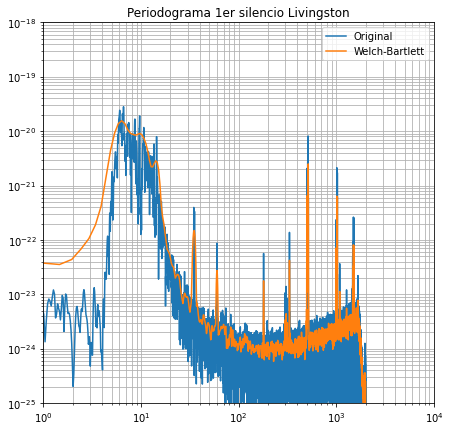

In [ ]:
data_selection = 2
plot_WB(silences[data_selection], autocorrelations[data_selection], psds[data_selection], psd_freqs[data_selection],  titles[data_selection]);

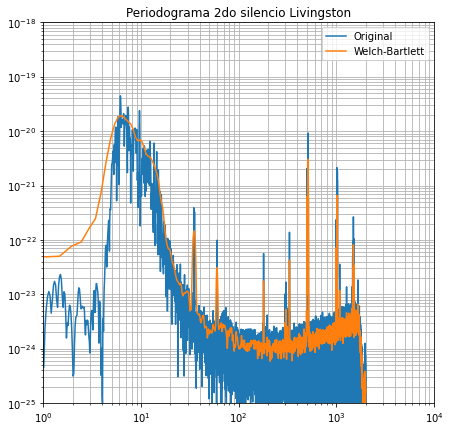

In [ ]:
data_selection = 3
plot_WB(silences[data_selection], autocorrelations[data_selection], psds[data_selection], psd_freqs[data_selection],  titles[data_selection]);
del data_selection

## Estimación del espectro mediante el método de Multitaper


El método de multitaper consiste en ventanerar una secuencia de datos de entrada temporales con diferentes ventanas o **tapers**, que en nuestro caso van a ser las secuencias DPSS (Discrete prolate spheroidal sequences por sus siglas en inglés). A cada una de estas señales de entradas ventaneadas, se le calcula la FFT y finalmente, se promedian todas las FFTs obtenidas para obtener el resultado final.

Las funciones DPSS son de la forma:

$$\omega_k (n) = \sqrt{\frac{2}{N+1}}sin\left( \frac{\pi(k+1)(n+1)}{N+1} \right)$$

En nuestro caso, utilizaremos el método **scipy.signal.windows.dpss()** para obtener estas funciones

A continuacion se puede observar la funcion que realiza el multitaper de una secuencia de datos.

In [ ]:
def multitaper(input_sig, NW=100, K=10):
  tapers = signal.windows.dpss(len(input_sig), NW, K)
  taped_signals = []
  
  #Aplicamos las ventanas sepianas a la señal
  for tape in tapers:
      taped_signals.append(tape*input_sig)

  #Calculamos la autocorrelacion de cada señal que fue tapeada
  autocor_taped_signals = []
  for t_signal in taped_signals:
    autocor = signal.correlate(t_signal, t_signal, method="fft")/ (2*len(t_signal))
    autocor_taped_signals.append(autocor)
  
  #Calculamos los periodogramas para cada autocorrelación para obtener el espectro de potencia
  periodograms = [] 
  for autocor in autocor_taped_signals:
    periodogram = np.abs(np.fft.fft(autocor))
    periodograms.append(periodogram)

  #Calculamos el promedio de los peridogramas
  avg_periodogram = np.mean(periodograms, axis=0)

  return avg_periodogram

In [ ]:
def plotMT(multitaper_periogram, freq_multitaper, psd, frec_vector,  title):  
  plt.figure(figsize=(7,7));
  plt.loglog(frec_vector, np.sqrt(psd), label="Original");
  #plt.loglog(freq_bktukey_1_H1, np.sqrt(spectre_bktukey_1_H1), label="Blackman Tukey");
  #plt.loglog(freq_1_H1_WL, np.sqrt(wL_1_H1) ,label="Welch-Bartlett");
  plt.loglog(freq_multitaper, np.sqrt(multitaper_periogram), label="Multitaper");
  plt.axis(plot_axis)
  plt.grid(axis='both', which='both');
  plt.title(title);
  plt.legend();

In [ ]:
start = time.time()
NW = 100
K = 10
multitaper_spectres = []
multitaper_freqs = []
for index, silence in enumerate(silences):
  multitaper_spectres.append(multitaper(silence, NW, K))
  multitaper_freqs.append(np.fft.fftfreq(len(multitaper_spectres[index]), d=1/fs))
end = time.time()
print("Execution time: ", end-start, "(segs)")

Execution time:  3.0526797771453857 (segs)


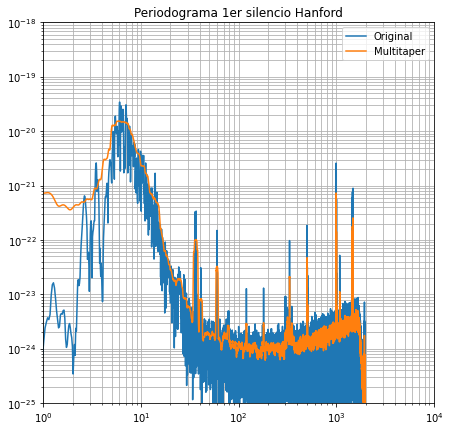

In [ ]:
data_selection = 0
plotMT(multitaper_spectres[data_selection],multitaper_freqs[data_selection], psds[data_selection], psd_freqs[data_selection],  titles[data_selection])

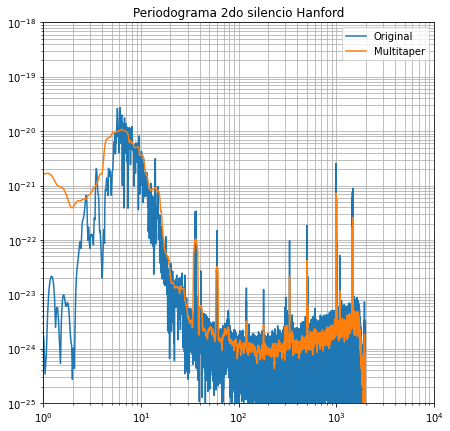

In [ ]:
data_selection = 1
plotMT(multitaper_spectres[data_selection],multitaper_freqs[data_selection], psds[data_selection], psd_freqs[data_selection],  titles[data_selection])

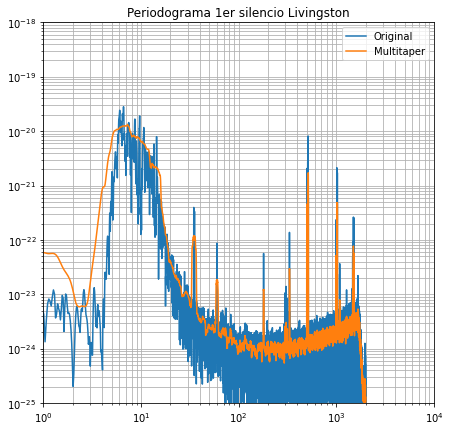

In [ ]:
data_selection = 2
plotMT(multitaper_spectres[data_selection],multitaper_freqs[data_selection], psds[data_selection], psd_freqs[data_selection],  titles[data_selection])

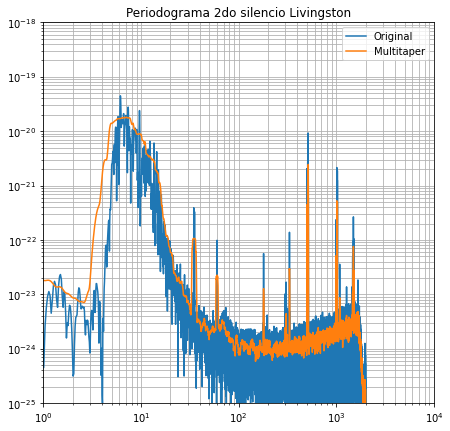

In [ ]:
data_selection = 3
plotMT(multitaper_spectres[data_selection],multitaper_freqs[data_selection], psds[data_selection], psd_freqs[data_selection],  titles[data_selection])

-Estimar la función de distribución de probabilidad y el espectro de potencia al
principio y al final de la señal de 32 s, a fin de validar la estacionaridad del ruido de
H1 y L1.

## Whitening
Vamos a realizar el blanqueamiento usando Blackam-Tuckey

In [ ]:
avgs_spectrum_bt = {
    "H1": np.mean(btuckey_spectres[0:2], axis=0),
    "L1": np.mean(btuckey_spectres[2:], axis=0)
}  

freq_spectrum_bt = {
    "H1": btuckey_freqs[0],
    "L1": btuckey_freqs[3]
}

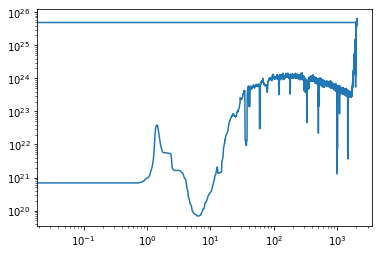

In [ ]:
white_filter = np.sqrt(1/avgs_spectrum_bt["H1"])
plt.loglog(freq_spectrum_bt["H1"], white_filter)

In [ ]:
filtered_strain = np.convolve(strain_H1, np.abs(np.fft.ifft(white_filter)), mode="same")

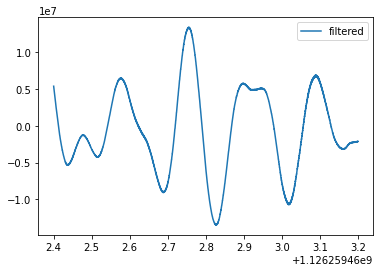

In [ ]:
# plt.figure(figsize=(40,5));
index_H1 = np.where(time_H1 >= 1126259462.4)[0][0]
plt.plot(time_H1[index_H1: (event_duration*4 + index_H1 )], filtered_strain[index_H1: (event_duration*4 + index_H1 )] , label="filtered")
# plt.plot(time_H1[index_H1: (event_duration + index_H1 )], strain_H1[index_H1: (event_duration + index_H1 )] label="original")
plt.legend()

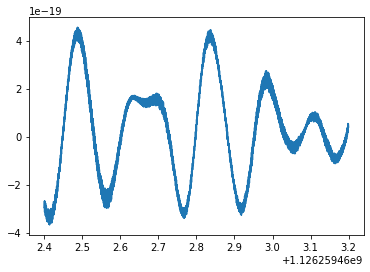

In [ ]:
# plt.figure(figsize=(40,5));
plt.plot(time_H1[index_H1: (event_duration*4 + index_H1 )], strain_H1[index_H1: (event_duration*4 + index_H1 )])

524287
262144


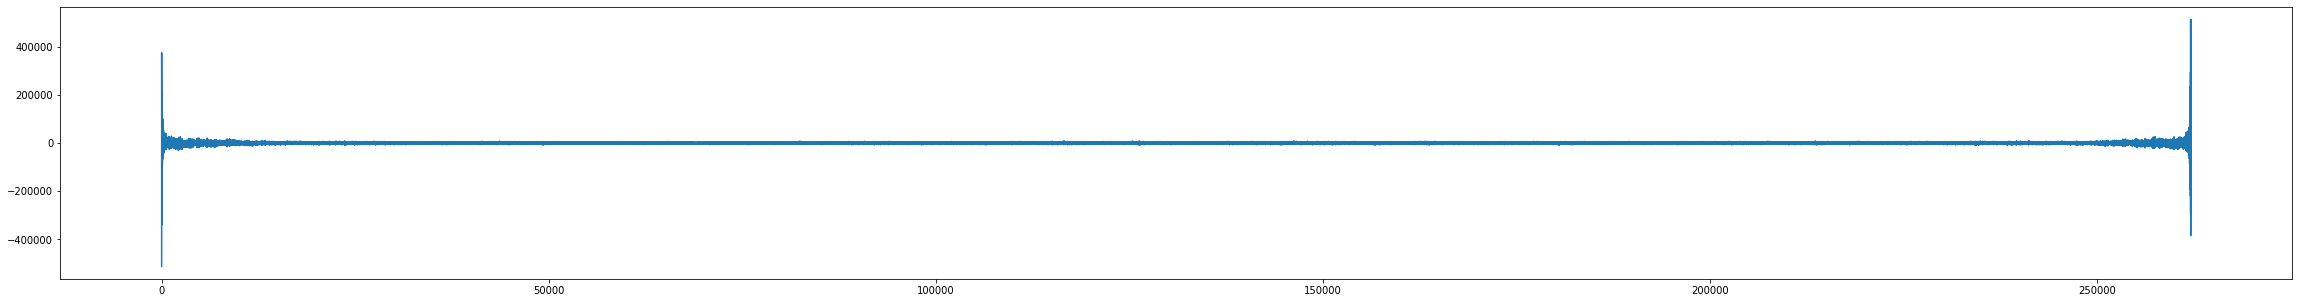

[-512543.98591091 -139913.6726646   375083.67106536 ...  106730.50701408
  512868.35225163   13812.07549753]


In [ ]:
strains = [strain_H1, strain_L1]
sil = []
for index, strain in enumerate(strains):
  silence_zero_padding = np.zeros(len(strain)*2)
  for i in range(len(silences[index*2])):
    silence_zero_padding[i] = silences[index*2][i]
  sil.append(silence_zero_padding)

psd_finals = []
freqs_finals = []
for silence in sil:
  auto_corr = signal.correlate(silence,silence,method="fft")/(2*len(silence)-1)**2
  freq_chosen, psd_chosen = do_btuckey(silence, auto_corr, fs, M=15)
  #f, pptx = signal.periodogram(silence, fs, scaling="spectrum")
  psd_finals.append(psd_chosen)
  freqs_finals.append(freq_chosen)

#print(len(np.fft.fft(sil[0])))
print(len(psd_finals[0]))
print(len(sil[0]))
#plt.loglog(freqs_finals[0],np.sqrt(psd_finals[0]))
#plt.show()

final_strains = []
for index, strain in enumerate(sil):
  fft_c = np.fft.fft(strains[index])
  freqs = np.fft.fftfreq(len(fft_c), d=1.0/fs)
  for i, freq in enumerate(freqs):
    index_f = np.where(freqs_finals[index] >= freq)[0][0]
    fft_c[i] = fft_c[i] / np.sqrt(psd_finals[index][index_f])
  final_strains.append(np.fft.irfft(fft_c))

plt.figure(figsize=(40,5));
plt.plot(final_strains[0])
plt.show()

print(final_strains[0])
  


In [ ]:
import scipy.io.wavfile

scipy.io.wavfile.write('./probando.wav', 4096, final_strains[0]*1e-8)

# Pruebas

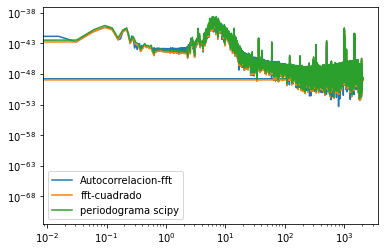

1.3411505957420556e-39
2.5970422698264616e-39


In [ ]:
# tamaño_ventana = 100
# señal_silencio = strain_H1
# señal_silencio = señal_silencio - np.mean(señal_silencio)
# #Metodo autocorrelacion y fft
# au = signal.correlate(señal_silencio,señal_silencio,method="fft")/len(señal_silencio)**2
# au = np.fft.fft(au)
# au = np.abs(au)
# freq_au = np.fft.fftfreq(len(au),d= 1/fs)
# #Metodo fft y cuadrado
# efefete = (np.abs(np.fft.fft(señal_silencio))/len(señal_silencio))**2
# freq_efefete = np.fft.fftfreq(len(efefete),d= 1/fs)
# # Metodo periodograma scipy
# freq_perio, perio = signal.periodogram(señal_silencio, fs, scaling="spectrum")
# plt.loglog(freq_au,au)
# plt.loglog(freq_efefete,efefete)
# plt.loglog(freq_perio,perio)
# plt.legend(["Autocorrelacion-fft","fft-cuadrado", "periodograma scipy"])
# plt.show()
# print(max(au))
# print(max(perio))

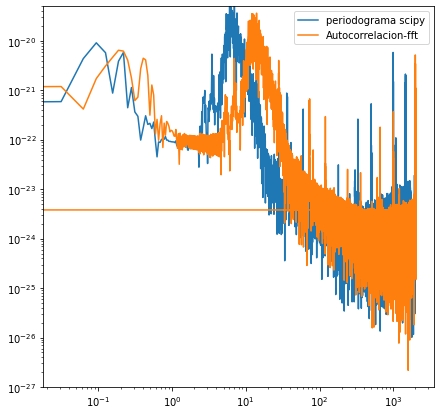

5.179093734896203e-20
5.096118395236184e-20


In [ ]:
tamaño_ventana = 100
señal_silencio = strain_H1
señal_silencio = señal_silencio - np.mean(señal_silencio)
#Metodo autocorrelacion y fft
au = signal.correlate(señal_silencio,señal_silencio, method="fft")/len(señal_silencio)**2
au = np.fft.fft(au)
au = np.abs(au)
freq_au = np.fft.fftfreq(len(au),d= 1/fs)
#Metodo fft y cuadrado
efefete = (  np.abs(np.fft.fft(señal_silencio)) / (len(señal_silencio))  )**2
freq_efefete = np.fft.fftfreq(len(efefete),d= 1/fs)
# Metodo periodograma scipy
freq_perio, perio = signal.periodogram(señal_silencio, fs, scaling="spectrum")
plt.figure(figsize=(7,7));

plt.ylim(10e-28,5e-20)
plt.loglog(freq_perio,np.sqrt(perio), label="periodograma scipy")
plt.loglog(freq_au,np.sqrt(2*au), label="Autocorrelacion-fft")
# plt.loglog(freq_efefete,np.sqrt(efefete), label="fft-cuadrado")

plt.legend()

plt.show()
print(max(np.sqrt(2*au)))
print(max(np.sqrt(perio)))

In [ ]:
rxx = np.correlate(silencio_1_H1, silencio_1_H1, mode="full")/ (2*len(silencio_1_H1)-1)

[0.6 1.6 2.8 1.6 0.6]
